In [1]:
import numpy as np
import os
import pandas as pd
import sys
sys.path.insert(0, "/Users/rocconoe/local/lib/python3.9/site-packages")
import lhapdf
#lhapdf.pathsPrepend('/home/sam/miniconda3/pkgs/share/LHAPDF')

> # Function & Class Definitions:

In [56]:
class PDF:
    """ 
    Class to store the PDF, so it is not constantly re-initialized (should be much quicker)
    """
    def __init__(self, name, set_id):
        self.pdf = lhapdf.mkPDF(name, set_id)
        self.quarks = {'d': 1, 'u': 2, 's': 3, 'c': 4, 'b': 5,
                       'db': -1, 'ub': -2, 'sb': -3, 'cb': -4, 'bb': -5}
        
    def __call__(self, i, xs, qs, nq):
        if isinstance(i, str):
            i = self.quarks[i]
        xfx = np.zeros([len(xs), nq])
        for ix, x in enumerate(xs):
            for iq in range (nq):
                xfx[ix, iq] = self.pdf.xfxQ(i, x, np.sqrt(qs[ix,iq]))
        return xfx

#    def __call__(self, i, xs, ys, E):
#        if isinstance(i, str):
#            i = self.quarks[i]
#        xfx = np.zeros([len(xs), len(ys)])
#        for ix, x in enumerate(xs):
#            for iy, y in enumerate(ys):
#                q           = np.sqrt(2*m_p*E*x*y)
#                xfx[ix, iy] = self.pdf.xfxQ(i, x, q)
#        return xfx

In [57]:
class Dataset:
    """
    Class to store the data from Huma in a nice to access format
    """
    def __init__(self, prefix):
        self.filenames = [os.path.join(prefix, f) for f in os.listdir(prefix) if os.path.isfile(os.path.join(prefix, f)) and 'swp' not in f]
        self.data = []
        for filename in self.filenames:
            pdf_set = filename.split('_')[-2]
            df = pd.read_csv(filename, sep='\s+', names=['E', 'Q2', 'x', 'y', 'F1', 'F2', 'sigma'], dtype=np.float64)
            df['pdf'] = pdf_set
            self.data.append(df)
        self.data = pd.concat(self.data)
        self.data = self.data.sort_values(by=['pdf', 'E'])
        
    def points(self):
        pdf_mask = self.data['pdf'] == 'cteq'
        return self.data[pdf_mask][['E', 'Q2', 'x', 'y']].to_numpy()
    
    def data(self, pdf_set):
        pdf_mask = self.data['pdf'] == pdf_set
        return self.data[pdf_mask][['F1', 'F2', 'sigma']]

In [40]:
a         = 1/137    # fine structure constant.
prefactor = 4*np.pi*(a**2)
m_p       = 0.938    # mass of proton in GeV.

In [41]:
def q2f(E, xs, ys):
    """
    Takes arrays of x and y values, and incoming electron beam energy. 
    Outputs corresponding array of q**2's.
    """
    q2 = np.empty([len(xs), len(ys)])
    for ix, x in enumerate(xs):
        for iy, y in enumerate(ys):
            q2[ix,iy] = 2*m_p*E*x*y # Thank you Noemi - derived in notes!
    return q2

def y(E,x,q2s):
    ys= np.empty[len(q2s)]
    for iq, q2 in enumerate(q2s):
        y[iq]=q2s[iq]/E/x/2/m_p
    return y2    
            

$$\begin{align} \frac{F_2^{ep}(x)}{x} &= \frac{4}{9}(u(x)+\bar{u}(x))+\frac{1}{9}(d(x)+\bar{d}(x))+\frac{1}{9}(s(x)+\bar{s}(x))+ ... \end{align}$$

In [65]:
def F2_ep(pdf, xs, qs, nq):
    """
    Quiggs Eq. ???
    """
    series = (4/9)*(pdf("u",xs,qs, nq) + pdf("ub",xs,qs, nq)) +\
             (1/9)*(pdf("d",xs,qs, nq) + pdf("db",xs,qs, nq)) +\
             (1/9)*(pdf("s",xs,qs, nq) + pdf("sb",xs,qs, nq)) +\
             (4/9)*(pdf("c",xs,qs, nq) + pdf("cb",xs,qs, nq)) #+\
         #    (1/9)*(fx_x(pdf_set,"t",xs,qs) + fx_x(pdf_set,"tbar",xs,qs)) +\
         #    (1/9)*(fx_x(pdf_set,"b",xs,qs) + fx_x(pdf_set,"bbar",xs,qs)) 
    return series

$$\begin{align} F_1(x) = \left\{
        \begin{array}{ll}
            0 & \quad \textrm{spin-zero partons} \\
            \left(\frac{1}{2x}\right)F_2(x) & \quad \textrm{spin-$\frac{1}{2}$ partons}
        \end{array}
    \right.\end{align}$$

In [43]:
def F1_ep(pdf, xs, qs, nq):
    """
    Quiggs Eq. ???
    Takes LHAPDF data set, incoming electron beam energy, array xs and ys of x and y values.
    """
    f1 = F2_ep(pdf,xs,qs, nq)
    for ix, x in enumerate(xs):
        f1[ix] *= (1/(2*x))       # this is suspect to break with array formats?
    return f1

$$\begin{align} \frac{d^2\sigma}{dxdy} &= \frac{4\pi \alpha^2 s}{Q^4}[F_2(x)(1-y)+F_1(x)xy^2]\end{align}$$

In [45]:
def functional(pdf, E, xs, ys):
    """
    Bracketed term calculation. Need LHAPDF data set, incoming electron beam energy, arrays xs and ys.
    """
    left = np.empty([len(xs), len(ys)])
    
    q2=q2f(E, xs, ys)
    for ix, x in enumerate(xs):
        for iy, y in enumerate(ys):
            left[ix,iy] = (1-y)
    right = np.empty([len(xs), len(ys)])
    for ix, x in enumerate(xs):
        for iy, y in enumerate(ys):
            right[ix,iy] = y**2*x
            
    return (F2_ep(pdf,xs,q2,len(ys))*left + F1_ep(pdf,xs,qs,len(ys))*right)

In [46]:
def cross_section(pdf, E, xs, ys, q2s):
    """
    Calculates d2sigma/dxdy. Need LHAPDF data set, incoming electron beam energy, arrays xs and ys.
    """
    s  = m_p**2 + 2*E * m_p     # invariant mass.
    cs = prefactor * s / q2f(E,xs,ys)**2 * functional(pdf,E,xs,ys)
    #cs = prefactor * s / q2s**2 * functional(pdf,E,xs,ys)
    return conversion(E,cs)

In [47]:
def conversion(E, cs):
    gevtocm = 0.19733**2*1e-26
    d2sig   = cs*gevtocm*1e+32/E
    return d2sig # double check this soon.

> # Testing Grounds:

In [11]:
obj = Dataset('NumbersHuma')

In [12]:
obj.points()

array([[3.00000000e+00, 1.40739000e-02, 5.00000000e-02, 5.00000000e-02],
       [3.00000000e+00, 2.81478000e-02, 5.00000000e-02, 1.00000000e-01],
       [3.00000000e+00, 4.22217000e-02, 5.00000000e-02, 1.50000000e-01],
       ...,
       [1.50000000e+01, 2.27293485e+01, 9.50000000e-01, 8.50000000e-01],
       [1.50000000e+01, 2.40663690e+01, 9.50000000e-01, 9.00000000e-01],
       [1.50000000e+01, 2.54033895e+01, 9.50000000e-01, 9.50000000e-01]])

In [13]:
obj.data

,E,Q2,x,y,F1,F2,sigma,pdf
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NumbersHuma/.DS
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NumbersHuma/.DS
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NumbersHuma/.DS
0,3.0,0.014074,0.05,0.05,0.000000,0.000000,0.000000,cteq
1,3.0,0.028148,0.05,0.10,0.000000,0.000000,0.000000,cteq
...,...,...,...,...,...,...,...,...
185,15.0,20.055308,0.95,0.75,0.000053,0.000053,0.000003,mmht
186,15.0,21.392328,0.95,0.80,0.000052,0.000052,0.000003,mmht
187,15.0,22.729349,0.95,0.85,0.000050,0.000050,0.000003,mmht
188,15.0,24.066369,0.95,0.90,0.000049,0.000049,0.000003,mmht


> # Let's compare tables:

In [14]:
# isolate 3 GeV entries.
df = obj.data
GeV = (df['E'] == 3) & (df['pdf'] == 'cteq')
bench = df[GeV]
bench

,E,Q2,x,y,F1,F2,sigma,pdf
0,3.0,0.014074,0.05,0.05,0.000000,0.000000,0.000000,cteq
1,3.0,0.028148,0.05,0.10,0.000000,0.000000,0.000000,cteq
2,3.0,0.042222,0.05,0.15,0.000000,0.000000,0.000000,cteq
3,3.0,0.056296,0.05,0.20,0.000000,0.000000,0.000000,cteq
4,3.0,0.070370,0.05,0.25,0.000000,0.000000,0.000000,cteq
...,...,...,...,...,...,...,...,...
185,3.0,4.011062,0.95,0.75,0.000118,0.000118,0.000192,cteq
186,3.0,4.278466,0.95,0.80,0.000114,0.000114,0.000185,cteq
187,3.0,4.545870,0.95,0.85,0.000110,0.000110,0.000178,cteq
188,3.0,4.813274,0.95,0.90,0.000106,0.000106,0.000172,cteq


In [58]:
E  = 3.0 ; nx = 19 ; ny = 19
xs = np.linspace(0.05,0.95,nx) ; ys = np.linspace(0.05,0.95,ny)
pdf = PDF('cteq66', 0)
# initialize only once, whoops!

In [17]:
"""
IMPORTANT: arrays have been flattened to accomodate the pandas dataframe.
a.flatten() is used in general, assuming that the lists format like so:
a[0] is 0th x-value; a[0][0] is the 0th y-value.
"""
s2 = cross_section(pdf,E,xs,ys).flatten()
q2 = q2f(E,xs,ys).flatten()

f1 = F1_ep(pdf,E,xs,ys).flatten()
f2 = F2_ep(pdf,E,xs,ys).flatten()

# create iterated x & y entries.
Cxs = np.empty([len(xs), len(ys)])
Cys = np.empty([len(xs), len(ys)])
for ix,x in enumerate(xs):
    for iy,y in enumerate(ys):
        Cxs[ix,iy] = x
        Cys[ix,iy] = y
cx = Cxs.flatten() ; cy = Cys.flatten()

d = {'E':3.0,'Q2':q2,'x':cx,'y':cy,'F1':f1,'F2':f2,'sigma':s2,'pdf':'cteq66'}
dfC = pd.DataFrame(d)
dfC

,E,Q2,x,y,F1,F2,sigma,pdf
0,3.0,0.01407,0.05,0.05,0.032532,0.003253,884.083937,cteq66
1,3.0,0.02814,0.05,0.10,0.066726,0.006673,431.287000,cteq66
2,3.0,0.04221,0.05,0.15,0.102247,0.010225,279.525165,cteq66
3,3.0,0.05628,0.05,0.20,0.138919,0.013892,203.394158,cteq66
4,3.0,0.07035,0.05,0.25,0.176616,0.017662,157.675139,cteq66
...,...,...,...,...,...,...,...,...
356,3.0,4.00995,0.95,0.75,0.000089,0.000169,0.000315,cteq66
357,3.0,4.27728,0.95,0.80,0.000085,0.000162,0.000260,cteq66
358,3.0,4.54461,0.95,0.85,0.000082,0.000156,0.000219,cteq66
359,3.0,4.81194,0.95,0.90,0.000080,0.000151,0.000186,cteq66


> # Visual comparison:

In [26]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


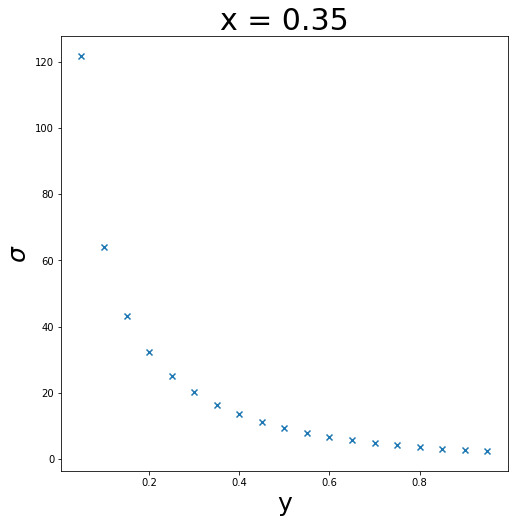

In [48]:
plt.figure(figsize=(8,8)) ; plt.rc('axes', labelsize=25, titlesize=30)

xval = 0.35 ; s = "x = {}".format(xval)
xm = dfC['x'] == xval
plt.scatter(dfC['y'][xm],dfC['sigma'][xm],marker='x')
plt.scatter(bench['y'][xm],bench['sigma'][xm],marker='x')
plt.xlabel('y') ; plt.ylabel('$\sigma$') ; plt.title(s)

plt.show()

In [19]:
print(dfC['sigma'][xm])

114    121.795443
115     64.026048
116     43.306528
117     32.209144
118     25.130115
119     20.161703
120     16.466579
121     13.613899
122     11.355804
123      9.537253
124      8.054729
125      6.835454
126      5.826118
127      4.986385
128      4.284949
129      3.697038
130      3.202757
131      2.793900
132      2.464932
Name: sigma, dtype: float64


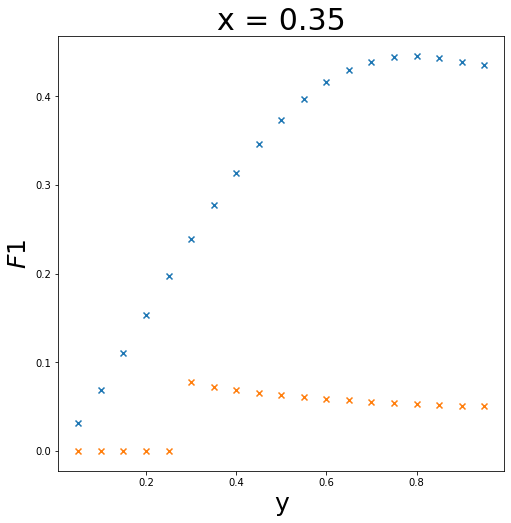

In [50]:
plt.figure(figsize=(8,8)) ; plt.rc('axes', labelsize=25, titlesize=30)

xval = 0.35 ; s = "x = {}".format(xval)
xm = dfC['x'] == xval
plt.scatter(dfC['y'][xm],dfC['F1'][xm],marker='x')
plt.scatter(bench['y'][xm],bench['F1'][xm],marker='x')
plt.xlabel('y') ; plt.ylabel('$F1$') ; plt.title(s)

plt.show()

In [63]:
E  = 3.0 ; nx = 1 ; ny = 19
xs = [0.35]
ys = np.linspace(0.05,0.95,ny)
q2 = q2f(E,xs,ys)
print(q2)

[[0.09849 0.19698 0.29547 0.39396 0.49245 0.59094 0.68943 0.78792 0.88641
  0.9849  1.08339 1.18188 1.28037 1.37886 1.47735 1.57584 1.67433 1.77282
  1.87131]]


[[0.02196088 0.04853796 0.07762115 0.10779503 0.13792973 0.16710401
  0.1945766  0.2197693  0.2422527  0.26173194 0.2780319  0.29108196
  0.30090063 0.3075805  0.31127387 0.31217921 0.31052888 0.30745246
  0.30448867]]


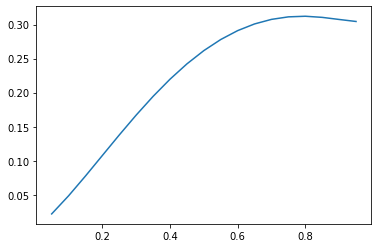

In [67]:
f1 = F1_ep(pdf,xs,q2,ny)
f2 = F2_ep(pdf,xs,q2,ny)

print(f2)
plt.plot(ys,f2[0,:])

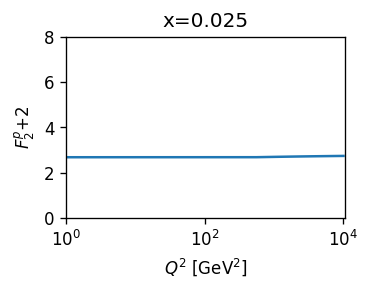

In [95]:
 E  = 3.0 ; nx = 1 ; ny = 19
xs = [0.025]
q2=np.zeros((nx,ny))
q2[0,:] = np.linspace(0.0,10000,ny)
f2 = F2_ep(pdf,xs,q2,ny)

figure(num=None, figsize=(3, 2), dpi=120, facecolor='w', edgecolor='k')

plt.plot(q2[0,:],f2[0,:]+2)
plt.ylim(0,8)
plt.xlim(1,)

plt.title('x=0.025')
plt.xlabel(r'$Q^2$ [GeV$^2$]')
plt.ylabel(r'$F_2^p$+2')
plt.xscale('log')

Text(0, 0.5, '$F_2^p$')

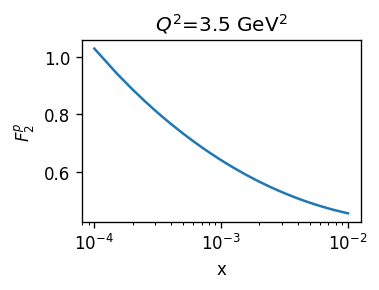

In [93]:
nx=200
ny=1
xs = np.linspace(0.0001,0.01,nx)
q2=np.zeros((nx,ny))
q2[:,0]=3.5
f2 = F2_ep(pdf,xs,q2,ny)
#q2 = q2f(E,xs,ys)
#up=pdf("u",xs,ys,E)
figure(num=None, figsize=(3, 2), dpi=120, facecolor='w', edgecolor='k')

plt.plot(xs,f2[:,0])
plt.xscale('log')

plt.title('$Q^2$=3.5 GeV$^2$')
plt.xlabel(r'x')
plt.ylabel(r'$F_2^p$')
#plt.ylim(0,8)
#plt.xlim(1,)